In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.0.0', '2.2.4-tf')

# Prepare data

In [2]:
ds = xr.open_dataset('./graphene_processed.nc')
ds

<xarray.Dataset>
Dimensions:       (sample: 29791, x: 80, x_c: 5, y: 30, y_c: 3)
Dimensions without coordinates: sample, x, x_c, y, y_c
Data variables:
    coarse_image  (sample, y_c, x_c) float64 ...
    fine_image    (sample, y, x) float64 ...
    strain        (sample) float64 ...
    stress        (sample) float64 ...

In [3]:
X = ds['coarse_image'].values  # the coarse 3x5 image seems enough
# X = ds['fine_image'].values  # the same model works worse on higher resolution image

y = ds['strain'].values

X = X[..., np.newaxis]  # add channel dimension
X.shape, y.shape

((29791, 3, 5, 1), (29791,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((23832, 3, 5, 1), (5959, 3, 5, 1))

# Train model

In [5]:
model = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, batch_size=32, epochs=20)

Train on 23832 samples
Epoch 1/20
23832/23832 [==============================] - 3s 115us/sample - loss: 0.0131
Epoch 2/20
23832/23832 [==============================] - 2s 92us/sample - loss: 0.0047
Epoch 3/20
23832/23832 [==============================] - 2s 94us/sample - loss: 0.0037
Epoch 4/20
23832/23832 [==============================] - 2s 90us/sample - loss: 0.0032
Epoch 5/20
23832/23832 [==============================] - 2s 88us/sample - loss: 0.0031
Epoch 6/20
23832/23832 [==============================] - 2s 99us/sample - loss: 0.0029
Epoch 7/20
23832/23832 [==============================] - 2s 100us/sample - loss: 0.0028
Epoch 8/20
23832/23832 [==============================] - 2s 100us/sample - loss: 0.0027
Epoch 9/20
23832/23832 [==============================] - 2s 100us/sample - loss: 0.0025
Epoch 10/20
23832/23832 [==============================] - 2s 102us/sample - loss: 0.0025
Epoch 11/20
23832/23832 [==============================] - 2s 103us/sample - loss: 0.0025
E

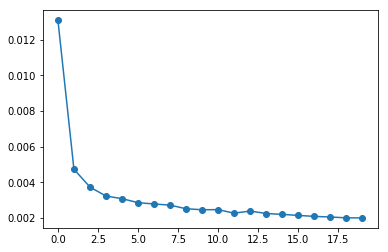

In [6]:
plt.plot(history.history['loss'], '-o')

# Evaluate model

In [7]:
%time y_train_pred = model.predict(X_train)
r2_score(y_train, y_train_pred)

CPU times: user 1.94 s, sys: 146 ms, total: 2.09 s
Wall time: 1.15 s


0.9454444149595516

In [8]:
%time y_test_pred = model.predict(X_test)
r2_score(y_test, y_test_pred)

CPU times: user 548 ms, sys: 38.8 ms, total: 586 ms
Wall time: 373 ms


0.9267094841065553

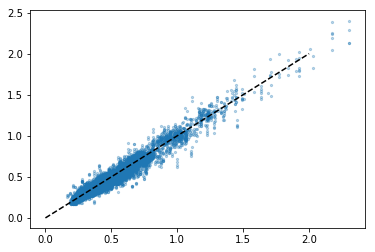

In [9]:
plt.scatter(y_train, y_train_pred, alpha=0.3, s=5)
plt.plot([0, 2], [0, 2], '--', c='k')

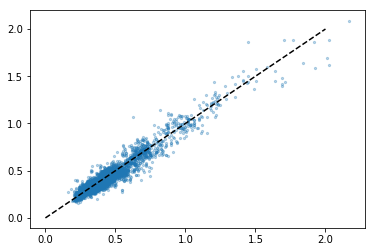

In [10]:
plt.scatter(y_test, y_test_pred, alpha=0.3, s=5)
plt.plot([0, 2], [0, 2], '--', c='k')